<a href="https://colab.research.google.com/github/GustavoKlehm/VisuAI/blob/main/VisuAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Instala o Detectron2 e dependências necessárias
!pip install -q detectron2 -U
!pip install -q opencv-python matplotlib scikit-learn

# Reinicia o runtime se necessário após a instalação
import torch, torchvision
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [5]:
import requests

# Baixar e salvar o arquivo de configuração (YAML)
yaml_url = "https://raw.githubusercontent.com/facebookresearch/detectron2/main/configs/Misc/fashionpedia/mask_rcnn_R_50_FPN_3x.yaml"
yaml_data = requests.get(yaml_url)
with open("fashionpedia.yaml", "wb") as f:
    f.write(yaml_data.content)

# Baixar os pesos do modelo
weights_url = "https://dl.fbaipublicfiles.com/detectron2/Fashionpedia/mask_rcnn_R_50_FPN_3x/model_final_f97cb7.pkl"
weights_data = requests.get(weights_url)
with open("model_final_f97cb7.pkl", "wb") as f:
    f.write(weights_data.content)


In [9]:
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2 import model_zoo
import torch

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # maior confiança
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

predictor = DefaultPredictor(cfg)


model_final_f10217.pkl: 178MB [00:01, 107MB/s]                           


Saving look_testeok.jpg to look_testeok.jpg


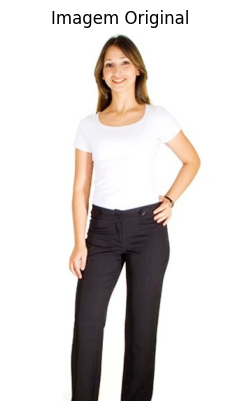

In [10]:
from google.colab import files
uploaded = files.upload()

import PIL.Image
from io import BytesIO

# Pega a primeira imagem
image_path = next(iter(uploaded))
im = cv2.imread(image_path)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

plt.imshow(im)
plt.axis("off")
plt.title("Imagem Original")
plt.show()

/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


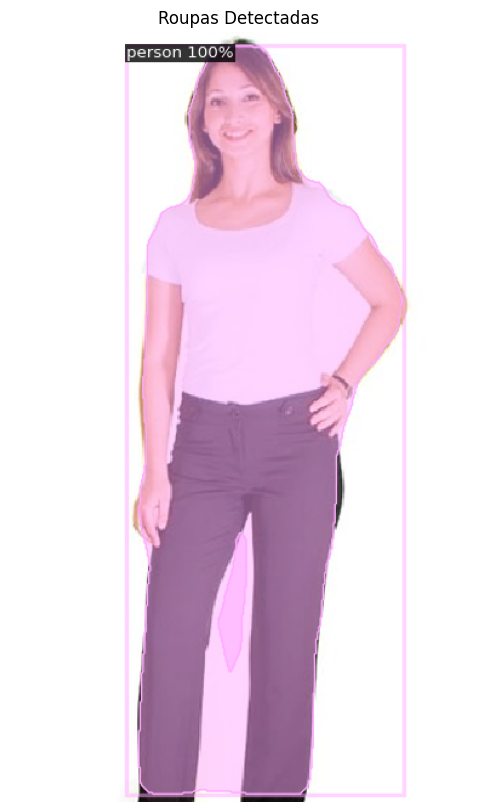

In [11]:
from detectron2.utils.visualizer import Visualizer

outputs = predictor(im)

v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

plt.figure(figsize=(10, 10))
plt.imshow(out.get_image()[:, :, ::-1])
plt.axis("off")
plt.title("Roupas Detectadas")
plt.show()


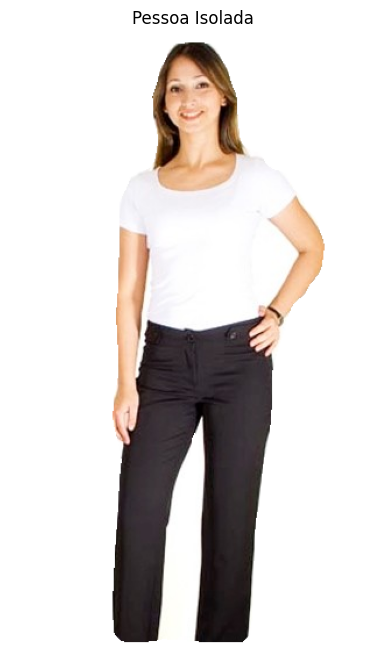

In [12]:
import numpy as np

# Pegando as instâncias detectadas
instances = outputs["instances"].to("cpu")
pred_classes = instances.pred_classes.numpy()
pred_masks = instances.pred_masks.numpy()

# Filtrar apenas máscaras da classe "pessoa" (classe 0 no COCO)
person_indices = np.where(pred_classes == 0)[0]

if len(person_indices) == 0:
    print("Nenhuma pessoa detectada na imagem.")
else:
    # Considerar apenas a primeira pessoa detectada
    person_mask = pred_masks[person_indices[0]]

    # Aplicar a máscara na imagem
    masked_image = im.copy()
    masked_image[~person_mask] = 255  # branco no fundo

    plt.figure(figsize=(8, 8))
    plt.imshow(masked_image)
    plt.axis("off")
    plt.title("Pessoa Isolada")
    plt.show()


Cores predominantes (sem tons de pele): [[254, 254, 254], [120, 165, 197], [219, 80, 92], [90, 53, 50], [49, 137, 196]]

Análise do look baseada em heurísticas:
As cores têm bom contraste, sugerindo ousadia e estilo marcante.


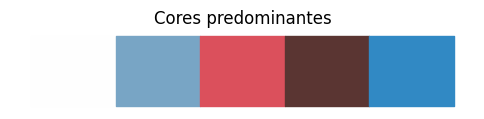

In [28]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import colorsys
import matplotlib.pyplot as plt

# Função para detectar se uma cor é possivelmente tom de pele
def is_skin_color(rgb_color):
    hsv = colorsys.rgb_to_hsv(rgb_color[0]/255.0, rgb_color[1]/255.0, rgb_color[2]/255.0)
    h, s, v = hsv
    return (0.0 <= h <= 0.12 or 0.9 <= h <= 1.0) and (0.1 < s < 0.6) and (0.4 < v < 0.95)

# Função para extrair cores dominantes ignorando tons de pele
def extrair_cores_predominantes(img_bgr, n_cores=5):
    imagem_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    pixels = imagem_rgb.reshape((-1, 3))
    pixels_filtrados = np.array([p for p in pixels if not is_skin_color(p)])

    if len(pixels_filtrados) == 0:
        return []

    kmeans = KMeans(n_clusters=min(n_cores, len(pixels_filtrados)), random_state=42)
    kmeans.fit(pixels_filtrados)
    cores = kmeans.cluster_centers_.astype(int).tolist()
    return cores

# Análise heurística da combinação
def analisar_combinacao_cores(cores):
    def rgb_to_hsv(color):
        return colorsys.rgb_to_hsv(color[0]/255.0, color[1]/255.0, color[2]/255.0)

    hsv_cores = [rgb_to_hsv(c) for c in cores]
    comentarios = []

    if len(hsv_cores) < 2:
        return "Não há cores suficientes para análise."

    tons = [h[0] for h in hsv_cores]

    if max(tons) - min(tons) < 0.1:
        comentarios.append("As cores são análogas, criando um look harmonioso e coeso.")
    elif any(abs(t1 - t2) > 0.4 for t1 in tons for t2 in tons if t1 != t2):
        comentarios.append("As cores têm bom contraste, sugerindo ousadia e estilo marcante.")
    else:
        comentarios.append("As cores são moderadamente contrastantes, indicando equilíbrio.")

    saturacoes = [h[1] for h in hsv_cores]
    valores = [h[2] for h in hsv_cores]

    if all(s > 0.6 for s in saturacoes):
        comentarios.append("O look é vibrante, com cores saturadas que chamam atenção.")
    elif all(s < 0.3 for s in saturacoes):
        comentarios.append("O look é mais sóbrio, com tons pastéis ou neutros.")

    if all(v > 0.7 for v in valores):
        comentarios.append("As cores são claras, sugerindo leveza e frescor.")
    elif all(v < 0.4 for v in valores):
        comentarios.append("As cores são escuras, transmitindo elegância ou seriedade.")

    return "\n".join(comentarios)

# Carregar imagem do Colab
caminho_imagem = "/content/look_teste.jpeg"
imagem = cv2.imread(caminho_imagem)

# Extração e análise
cores_filtradas = extrair_cores_predominantes(imagem)
print("Cores predominantes (sem tons de pele):", cores_filtradas)

if cores_filtradas:
    resultado = analisar_combinacao_cores(cores_filtradas)
    print("\nAnálise do look baseada em heurísticas:")
    print(resultado)

    # Visualizar as cores extraídas
    plt.figure(figsize=(6, 1))
    for i, cor in enumerate(cores_filtradas):
        plt.fill_between([i, i+1], 0, 1, color=np.array(cor)/255)
    plt.axis("off")
    plt.title("Cores predominantes")
    plt.show()
else:
    print("Não foram encontradas cores suficientes para análise.")
